<a href="https://colab.research.google.com/github/jermwatt/ocr_preprocessing/blob/main/ocr_preprocessing_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# if running in collab pull repo and install requirements
if os.getenv("COLAB_RELEASE_TAG"):
    !git clone https://github.com/jermwatt/ocr_preprocessing.git
    %cd ocr_preprocessing
    !pip install -r requirements.txt
    !sudo apt install tesseract-ocr

# Pre-processing steps for ocr

- ocr is a classic example of an "ai pipeline" that is not just a single ai model (ocr)
- this is true whether you use a "classic" ocr model - that is, one made explicitly to detect text-symbols - or a "transformer" model - a vllm finetuned for ocr like tasks - pre and post processing are almost always necessary
- in this notebook, we describe several standard preprocessing steps for ocr
- stick around here to see how all this stuff works, or fire up the streamlit app (see this repo's `README.md`) locally to start playing around immediately

---

- significant pre and post processing steps are almost always necessary to achieve even decent results, and all of these steps together are a true "ocr pipeline"
- post-processing involves taking the output of ocr is almost universally performed when using detection-based ocr models like the popular [tesseract](https://github.com/tesseract-ocr/tesseract)
- we will discuss these in a future notebook
- our discussion will center on steps towards preparing the image below as best as possilbe for ocr
- looks like a black rectangle doesn't it?  there's actually something there - we'll see by applying preprocessing

<img src="./data/input/seal_rotated.png" width="50%">

## Pre-processing steps

- pre-processing is extremely helpful, almost a necessity, for most ocr pipeline applications
- here we illustrate the following common steps in python
    1.  pixel intensity normalization: standard image normalization step: ensure all values in input image lie in proper range ([0,255])
    2.  image denoising: cleans up image
    3.  grayscale: convert image to grayscale
    4.  deskewing: ensure image is properly rotated linearly
    5.  binarization: convert grayscale image to binary

- generally speaking most of these steps are sensible to apply to data before processing with any AI model - e.g., normalization is good practice for any process used frequently
- the final binarization severely changes the input image, but is helpful since our goal is just to extract its text
- the code for these steps is below, along with a helper function to illustrate each step
- [opencv](https://github.com/opencv/opencv-python) is a common tool for many processing steps like those below
- we also use the helpful [deskew](https://github.com/sbrunner/deskew) library
- we run the code and discuss afterwards 

In [4]:
import cv2
import math
import numpy as np
from PIL import Image
from typing import Tuple
import matplotlib.pyplot as plt  
from deskew import determine_skew


def deskew_image(image: np.ndarray) -> np.ndarray:
    angle = determine_skew(image)
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=(0, 0, 0))


def preprocess_image(img_path: str, threshold_val: int = 235) -> Tuple:  
    img_orig = Image.open(img_path) 
    img_orig=np.array(img_orig)  
    img_orig=cv2.cvtColor(img_orig, cv2.COLOR_RGB2BGR)  
 
    # normalize
    img_norm = cv2.normalize(img_orig, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # denoise
    img_denoise = cv2.bilateralFilter(img_norm,5, 55,60)
    
    # grayscale
    img_gray = cv2.cvtColor(img_denoise, cv2.COLOR_BGR2GRAY)
    
    # skew correction
    img_deskew = deskew_image(img_gray)
    
    # threshold
    _, img_thresh = cv2.threshold(img_deskew, threshold_val, 255, 1)


    return img_orig, img_norm, img_denoise, img_gray, img_deskew, img_thresh


def plot_processing_images(img_orig: np.ndarray,
                           img_norm: np.ndarray,
                           img_denoise: np.ndarray, 
                           img_gray: np.ndarray, 
                           img_deskew: np.ndarray, 
                           img_thresh: np.ndarray) -> None:
    fig, axarr = plt.subplots(nrows=3, ncols=2, figsize=(8, 8));
    fig.tight_layout(); 

    axarr[0,0].imshow(img_orig);
    axarr[0,0].set_xticks([]);
    axarr[0,0].set_yticks([]);
    axarr[0,0].set_title("original (1)");
    
    axarr[0,1].imshow(img_norm);
    axarr[0,1].set_xticks([]);
    axarr[0,1].set_yticks([]);
    axarr[0,1].set_title("color normalized (2)");

    axarr[1,0].imshow(img_denoise);
    axarr[1,0].set_xticks([]);
    axarr[1,0].set_yticks([]);
    axarr[1,0].set_title("denoised (3)");

    axarr[1,1].imshow(img_gray, cmap='gray');
    axarr[1,1].set_xticks([]);
    axarr[1,1].set_yticks([]);
    axarr[1,1].set_title("gray (4)");

    axarr[2,0].imshow(img_deskew, cmap='gray');
    axarr[2,0].set_xticks([]);
    axarr[2,0].set_yticks([]);
    axarr[2,0].set_title("deskew (5)");

    axarr[2,1].imshow(img_thresh, cmap='gray');
    axarr[2,1].set_xticks([]);
    axarr[2,1].set_yticks([]);
    axarr[2,1].set_title("thresh (6)");

- now we execute the `preprocess_image` function, which runs the preprocessing steps listed above
- note we have left a single variable for selection here - `threshold_val`
- this value is fed to the binarization function, anything in the range `[0,threshold_val)` is mapped to zero, while the remainder `[threshold_val,255]` is mapped to 255
- this is the most important parameter to select carefully for our usecase

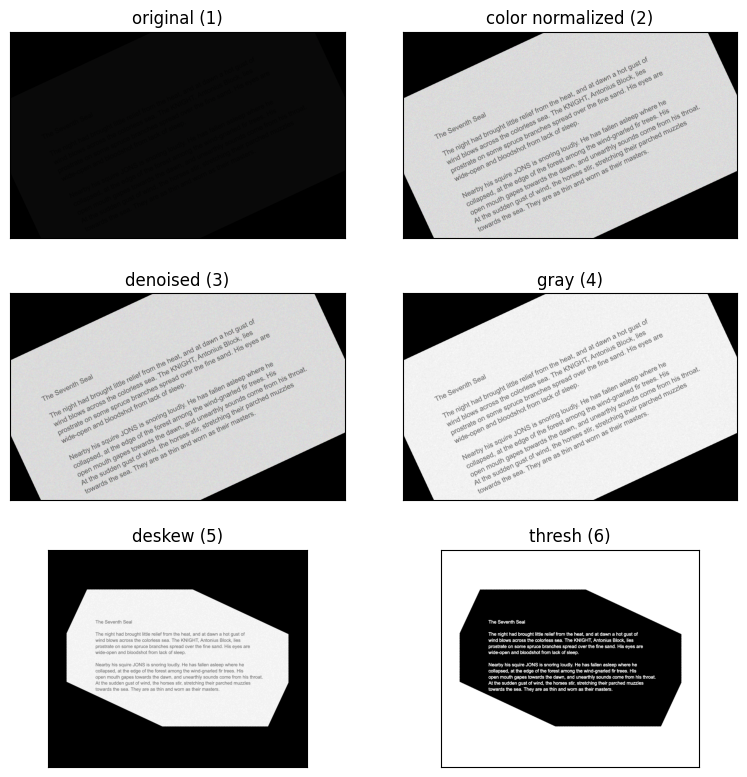

In [5]:
# run preprocessing
img_path = 'data/input/seal_rotated.png'
threshold_val=200
img_orig, img_norm, img_denoise, img_gray, img_deskew, img_thresh = preprocess_image(img_path, threshold_val)
plot_processing_images(img_orig, img_norm, img_denoise, img_gray, img_deskew, img_thresh)

- let's take a closer look at the final product - the output of thresholding

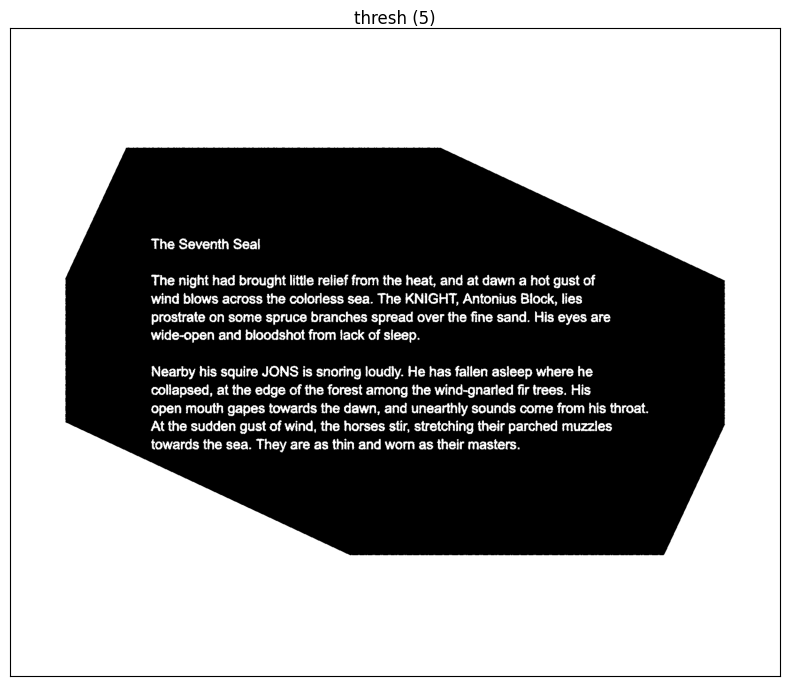

In [6]:
import matplotlib.pyplot as plt

fig, sub = plt.subplots(nrows=1, ncols=1, figsize=(8, 8));
sub.imshow(img_thresh, cmap='gray')
sub.set_xticks([]);
sub.set_yticks([]);
sub.set_title("thresh (5)", wrap=True, ha='center',va="top")
fig.tight_layout(); 

- the final processed image - output by step 5 binarization - is what we will feed into the ocr model next
- this drastically simplifies the image, making it much easier for ocr to work well
- to see the effect of `threshold_val` lets pick a few other values for this parameter, process with them, and plot the results
- some choices of this value are very helpful, others not so much

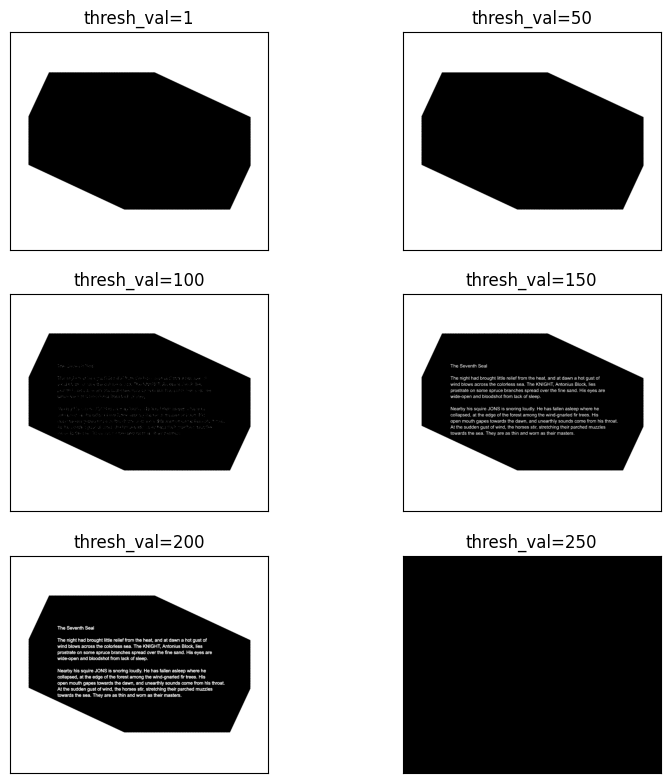

In [7]:
import matplotlib.pyplot as plt

threshold_test_imgs = []
test_threshold_vals = [1,50,100,150,200,250]
for threshold_val in test_threshold_vals:
    img_orig, img_norm, img_denoise, img_gray, img_deskew, img_thresh_test = preprocess_image(img_path, threshold_val)
    threshold_test_imgs.append(img_thresh_test)

fig, axarr = plt.subplots(nrows=3, ncols=2, figsize=(8, 8));
fig.tight_layout(); 

axarr[0,0].imshow(threshold_test_imgs[0], cmap='gray');
axarr[0,0].set_xticks([]);
axarr[0,0].set_yticks([]);
axarr[0,0].set_title(f"thresh_val={test_threshold_vals[0]}");

axarr[0,1].imshow(threshold_test_imgs[1], cmap='gray');
axarr[0,1].set_xticks([]);
axarr[0,1].set_yticks([]);
axarr[0,1].set_title(f"thresh_val={test_threshold_vals[1]}");

axarr[1,0].imshow(threshold_test_imgs[2], cmap='gray');
axarr[1,0].set_xticks([]);
axarr[1,0].set_yticks([]);
axarr[1,0].set_title(f"thresh_val={test_threshold_vals[2]}");

axarr[1,1].imshow(threshold_test_imgs[3], cmap='gray');
axarr[1,1].set_xticks([]);
axarr[1,1].set_yticks([]);
axarr[1,1].set_title(f"thresh_val={test_threshold_vals[3]}");

axarr[2,0].imshow(threshold_test_imgs[4], cmap='gray');
axarr[2,0].set_xticks([]);
axarr[2,0].set_yticks([]);
axarr[2,0].set_title(f"thresh_val={test_threshold_vals[4]}");

axarr[2,1].imshow(threshold_test_imgs[5], cmap='gray');
axarr[2,1].set_xticks([]);
axarr[2,1].set_yticks([]);
axarr[2,1].set_title(f"thresh_val={test_threshold_vals[5]}");

- what if your image has both dark and light text?
- binarize twice - once high threshold, one low

- with pre-processing complete we can now process our thresholded image through ocr
- here we use the popular [pytesseract](https://github.com/madmaze/pytesseract)
- we use a custom option:
    - [page segmentation mode (psm)](https://pyimagesearch.com/2021/11/15/tesseract-page-segmentation-modes-psms-explained-how-to-improve-your-ocr-accuracy/): tesseract allows a user to input different assumptions about where and how text is present in an input image.  we use the default selection 3 which makes broad assumption about the text in our input image(s) and attempts to adjust to whatever structure exists therein
- we process our original image and the thresholded versions for comparison
- text extracted from the heavily processed threshold image is much better

In [9]:
import pytesseract

# run ocr and clean up the result a bit
text_from_orig_img = pytesseract.image_to_string(img_orig, lang='eng',config="--psm 3")
text_from_orig_img = text_from_orig_img.replace("\n", " ").strip()
print(f'text imputed from original image --> "{text_from_orig_img}"')

text_from_thresh_img = pytesseract.image_to_string(img_thresh, lang='eng',config="--psm 3")
text_from_thresh_img = text_from_thresh_img.replace("\n", " ").strip()
print(f'text imputed from threshold image --> "{text_from_thresh_img}"')

text imputed from original image --> ""
text imputed from threshold image --> "The Seventh Seal  The night had brought little relief from the heat, and at dawn a hot gust of wind blows across the colorless sea. The KNIGHT, Antonius Block, lies prostrate on some spruce branches spread over the fine sand. His eyes are wide-open and bloodshot from lack of sleep.  Nearby his squire JONS is snoring loudly. He has fallen asleep where he collapsed, at the edge of the forest among the wind-gnaried fir trees. His  open mouth gapes towards the dawn, and unearthly sounds come from his throat. At the sudden gust of wind, the horses stir, stretching their parched muzzles towards the sea. They are as thin and worn as their masters."


- notice: with our choice of parameters no text was detected on the original image
- lets process one more time and illustrate the detections in each case

In [10]:
import copy
from pytesseract import Output
import cv2

def process_and_plot_detections(img: np.ndarray) -> None:
    plot_img = copy.deepcopy(img)        
    plot_img_template = copy.deepcopy(img)
    d = pytesseract.image_to_data(plot_img, config="--psm 3", output_type=Output.DICT)
    if len(plot_img.shape) < 3:
        plot_img_template = np.zeros(plot_img.shape + (3,))
        plot_img_template[:,:,0] = plot_img
        plot_img_template[:,:,1] = plot_img
        plot_img_template[:,:,2] = plot_img

    n_boxes = len(d['level'])
    for i in range(n_boxes):
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        if w != plot_img_template.shape[1] and h != plot_img_template.shape[0]:
            text = d["text"][i]
            cv2.rectangle(plot_img_template, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(plot_img_template, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.75, (0, 0, 255), 3) # thank you --> https://pyimagesearch.com/2020/05/25/tesseract-ocr-text-localization-and-detection/
    plt.imshow(plot_img_template.astype('uint8'))
    plt.axis("off")


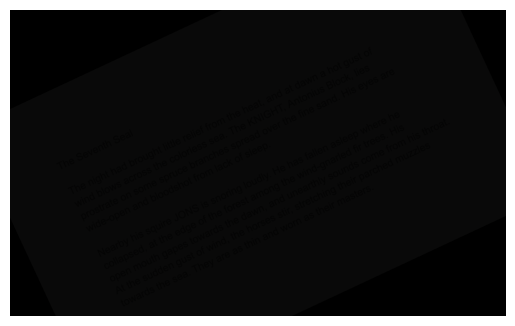

In [11]:
process_and_plot_detections(img_orig)

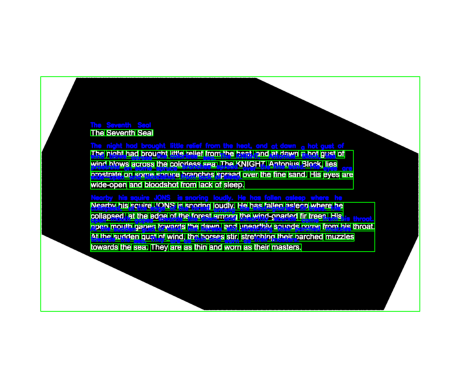

In [12]:
process_and_plot_detections(img_thresh)

- fire up the streamlit app (see this repo's `README.md`) locally to start playing around with this kind of stuff immediately